# Receiver Module — Interactive Exploration

This notebook provides an interactive, visual companion to the Receiver node
in Jacinta. It is intended for contributors and users who want to:

- Understand how the Receiver maps bounded inputs into an unbounded space.
- Inspect the effect of different bound configurations (fully / partially bounded / unbounded).
- Verify numerical behavior near the boundaries.
- Experiment with dynamic dimensionality and serialization.

> **Note:** This notebook focuses *only* on the Receiver module and is meant
> to complement the `Receiver.py` implementation and `Receiver.md` documentation.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Enable inline plots if running in a classic Jupyter environment
%matplotlib inline

# Optional: tweak some global plotting defaults for readability
plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

from jacinta.nodes import Receiver

## 1. Basic Receiver configurations

In this section we will:

- Instantiate `Receiver` objects with different bound patterns.
- Inspect their internal configuration (`min_x`, `max_x`, `has_bounds`).
- Apply `process_forward` on simple test vectors.

These examples are meant as sanity checks and a starting point for further
experiments.

In [2]:
# Example 1 — Fully bounded dimension
r_full = Receiver(size=1, min_x=0.0, max_x=1.0)

# Display internal configuration
print("=== Fully bounded Receiver ===")
print(f"min_x: {r_full.min_x}")
print(f"max_x: {r_full.max_x}")
print(f"has_bounds: {r_full.has_bounds}")

=== Fully bounded Receiver ===
min_x: [0.]
max_x: [1.]
has_bounds: [ True]


In [3]:
# Example 2 — Mixed bounds (bounded + unbounded + partially bounded)
r_mixed = Receiver(
    size=4,
    min_x=[0.0, np.nan, 0.0, np.nan],
    max_x=[1.0, np.nan, np.nan, 5.0],
)

# Display internal configuration
print("=== Mixed Receiver ===")
print(f"min_x: {r_mixed.min_x}")
print(f"max_x: {r_mixed.max_x}")
print(f"has_bounds: {r_mixed.has_bounds}")

=== Mixed Receiver ===
min_x: [ 0. nan  0. nan]
max_x: [ 1. nan nan  5.]
has_bounds: [ True False False False]


## 2. Visualizing the transformation

To understand how the Receiver's transformation works, we can visualize how
a bounded input interval `[min, max]` is mapped into the unbounded real line
via the artanh-based transform.

The following plot sweeps an input value `x` across the entire bounded range
and shows its transformed counterpart `y = Receiver.process_forward(x)`.

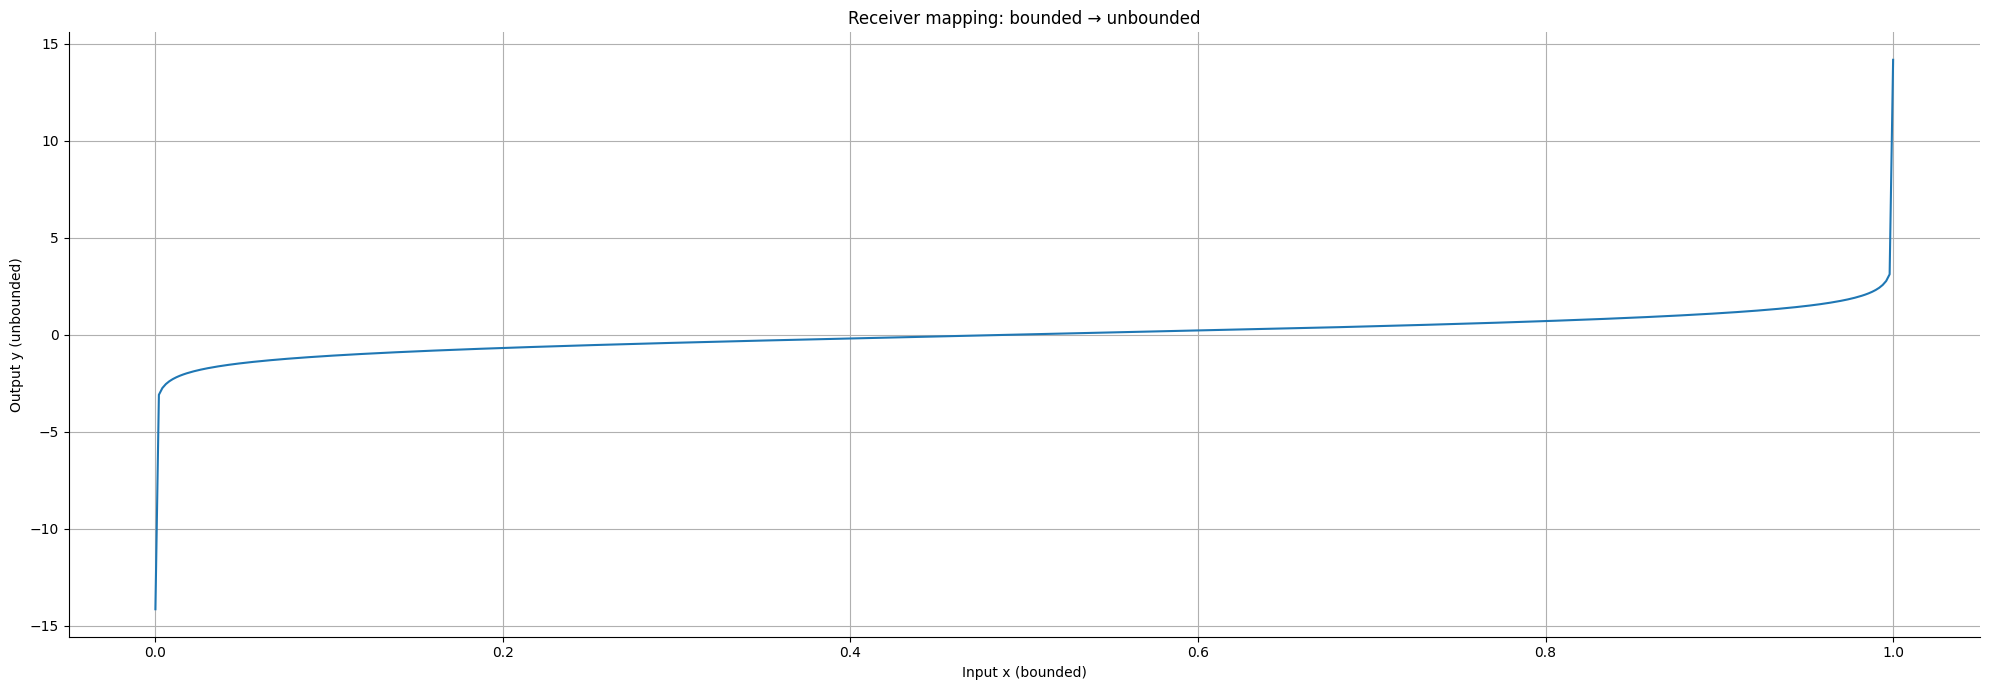

In [4]:
def visualize_receiver(
    receiver: Receiver,
    min_x: float = 0.0,
    max_x: float = 1.0,
    n_points: int = 500,
):
    """Plot the transformation applied by a Receiver on a single bounded dimension."""
    x = np.linspace(min_x, max_x, n_points)
    y = np.array([receiver.process_forward(np.array([xi]))[0] for xi in x])
    
    plt.figure()
    plt.plot(x, y)
    plt.title("Receiver mapping: bounded → unbounded")
    plt.xlabel("Input x (bounded)")
    plt.ylabel("Output y (unbounded)")
    plt.tight_layout()
    plt.show()


visualize_receiver(r_full)

### Observations

- Values near the middle of `[min, max]` map close to 0.
- Approaching the boundaries causes the output to grow rapidly toward ±∞.
- This ensures that the transformation is smooth and bijective but avoids
  singularities using a small epsilon margin.

Next, let's explore how the Receiver behaves when bounds are mixed or partial.

## 3. Mixed bounds and multi-dimensional behavior

In many practical cases, only some dimensions are fully bounded, while others
are partially bounded or completely unbounded.

In this section we will:

- Reuse the `r_mixed` Receiver defined above.
- Generate sample vectors and inspect how each dimension is transformed.
- Visualize the per-dimension mapping for a multi-dimensional Receiver.

In [5]:
# Generate a small batch of example inputs for the mixed Receiver
X_mixed = np.array([
    [0.0,   -3.0,   0.0,  0.0],   # on lower bound of dim 0
    [0.5,   -1.0,   2.0,  2.5],   # mid-range values
    [1.0,   0.0,    5.0,  5.0],   # on upper bound of dim 0
    [0.25,  1.5,    1.0,  4.9],   # close to upper bound of dim 3
], dtype=float)

Y_mixed = np.array([r_mixed.process_forward(x) for x in X_mixed])

print(f"Input batch (X_mixed):\n{X_mixed}")
print(f"\nTransformed batch (Y_mixed):\n{Y_mixed}")
print(f"\nhas_bounds: {r_mixed.has_bounds}")

Input batch (X_mixed):
[[ 0.   -3.    0.    0.  ]
 [ 0.5  -1.    2.    2.5 ]
 [ 1.    0.    5.    5.  ]
 [ 0.25  1.5   1.    4.9 ]]

Transformed batch (Y_mixed):
[[-14.16209521  -3.           0.           0.        ]
 [  0.          -1.           2.           2.5       ]
 [ 14.16209521   0.           5.           5.        ]
 [ -0.54930614   1.5          1.           4.9       ]]

has_bounds: [ True False False False]


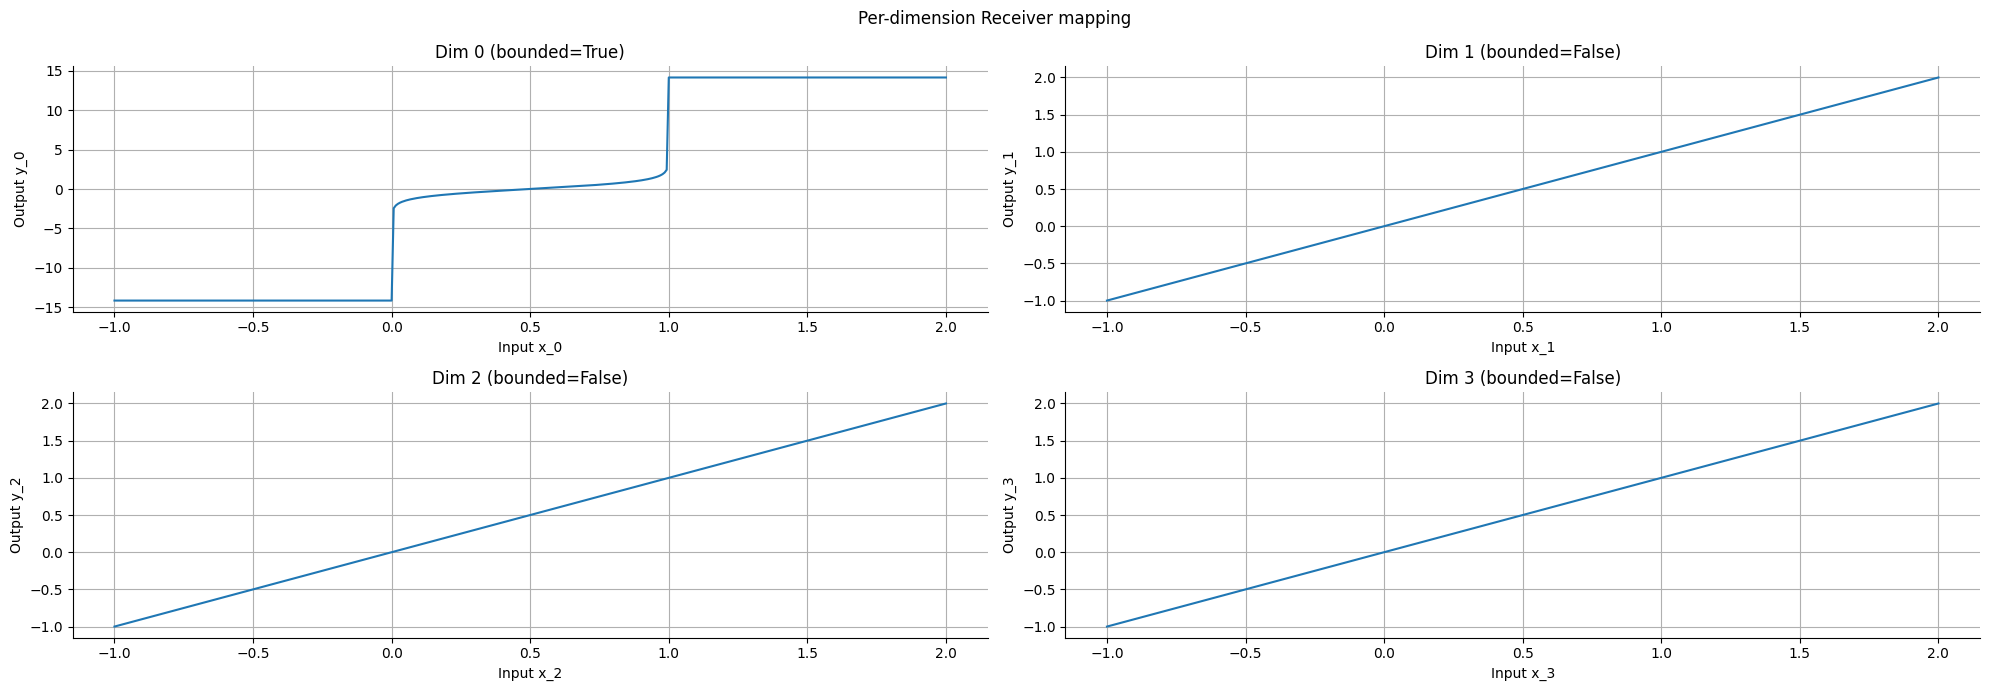

In [6]:
def visualize_multidim_receiver(receiver: Receiver, n_points: int = 400):
    """For each dimension of the Receiver, plot how x_i is transformed into y_i."""
    N = receiver.N
    n_cols = min(N, 2)
    n_rows = int(np.ceil(N / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, squeeze=False)

    for i in range(N):
        ax = axes[i // n_cols][i % n_cols]

        # Use a generic range for visualization
        x_min, x_max = -1.0, 2.0
        x = np.linspace(x_min, x_max, n_points)

        # Build full input vectors: vary only dim i, keep others at 0
        X = np.zeros((n_points, N), dtype=float)
        X[:, i] = x

        y = np.array([receiver.process_forward(row)[i] for row in X])

        ax.plot(x, y)
        ax.set_title(f"Dim {i} (bounded={receiver.has_bounds[i]})")
        ax.set_xlabel(f"Input x_{i}")
        ax.set_ylabel(f"Output y_{i}")

    fig.suptitle("Per-dimension Receiver mapping")
    plt.tight_layout()
    plt.show()


visualize_multidim_receiver(r_mixed)


### Observations

- Dimensions marked as `bounded=True` exhibit the characteristic S-shaped
  mapping from a finite interval into the real line.
- Unbounded or partially bounded dimensions appear as identity-like mappings
  in these plots, because `Receiver.process_forward` leaves them unchanged.
- Together, this allows Jacinta to mix heterogeneous input types in a single
  internal representation, while only "unbounding" those that truly live
  in a finite interval.

## 4. Edge cases and numerical stability

The Receiver uses an artanh-based mapping, which would normally diverge to
±∞ at the exact boundaries of the interval.

To avoid numerical issues, the implementation clamps the normalized values
slightly away from -1 and 1 using a small epsilon (`eps`).

In this section we:

- Probe inputs very close to the bounds.
- Check that the outputs remain finite.
- Inspect how the choice of `eps` affects the maximum magnitude of the output.

In [7]:
def probe_near_bounds(
    receiver: Receiver,
    margin_factors: tuple[float] = (1.0, 1e-3, 1e-6, 1e-9, 1e-12, 1e-15, 0.0),
):
    """
    For each bounded dimension, sample values extremely close to the bounds
    and print the corresponding transformed outputs.
    """
    print("=== Numerical stability probe near bounds ===")
    for i in range(receiver.N):
        if not receiver.has_bounds[i]:
            continue

        lo, hi = receiver.min_x[i], receiver.max_x[i]
        span = hi - lo

        print(f"\nDimension {i} with bounds [{lo}, {hi}]")
        for factor in margin_factors:
            # Points just above the lower bound and just below the upper bound
            x_lo = lo + factor * span
            x_hi = hi - factor * span

            y_lo = receiver.process_forward(np.eye(receiver.N)[i] * x_lo)[i]
            y_hi = receiver.process_forward(np.eye(receiver.N)[i] * x_hi)[i]

            print(f"  factor={factor:>8.1e} | x_lo={x_lo:.12f}, y_lo={y_lo:.6f} | "
                  f"x_hi={x_hi:.12f}, y_hi={y_hi:.6f}")


probe_near_bounds(r_full)

=== Numerical stability probe near bounds ===

Dimension 0 with bounds [0.0, 1.0]
  factor= 1.0e+00 | x_lo=1.000000000000, y_lo=14.162095 | x_hi=0.000000000000, y_hi=-14.162095
  factor= 1.0e-03 | x_lo=0.001000000000, y_lo=-3.453377 | x_hi=0.999000000000, y_hi=3.453377
  factor= 1.0e-06 | x_lo=0.000001000000, y_lo=-6.907755 | x_hi=0.999999000000, y_hi=6.907755
  factor= 1.0e-09 | x_lo=0.000000001000, y_lo=-10.361633 | x_hi=0.999999999000, y_hi=10.361633
  factor= 1.0e-12 | x_lo=0.000000000001, y_lo=-13.815522 | x_hi=0.999999999999, y_hi=13.815522
  factor= 1.0e-15 | x_lo=0.000000000000, y_lo=-14.162095 | x_hi=1.000000000000, y_hi=14.162095
  factor= 0.0e+00 | x_lo=0.000000000000, y_lo=-14.162095 | x_hi=1.000000000000, y_hi=14.162095


/Users/pablo/Desktop/TheLab/theconsmind/github/jacinta/src/jacinta/nodes/Receiver.py:195: RuntimeWarning: divide by zero encountered in log
  y[idx] = 0.5 * np.log((1 + x) / (1 - x))
/Users/pablo/Desktop/TheLab/theconsmind/github/jacinta/src/jacinta/nodes/Receiver.py:195: RuntimeWarning: divide by zero encountered in divide
  y[idx] = 0.5 * np.log((1 + x) / (1 - x))


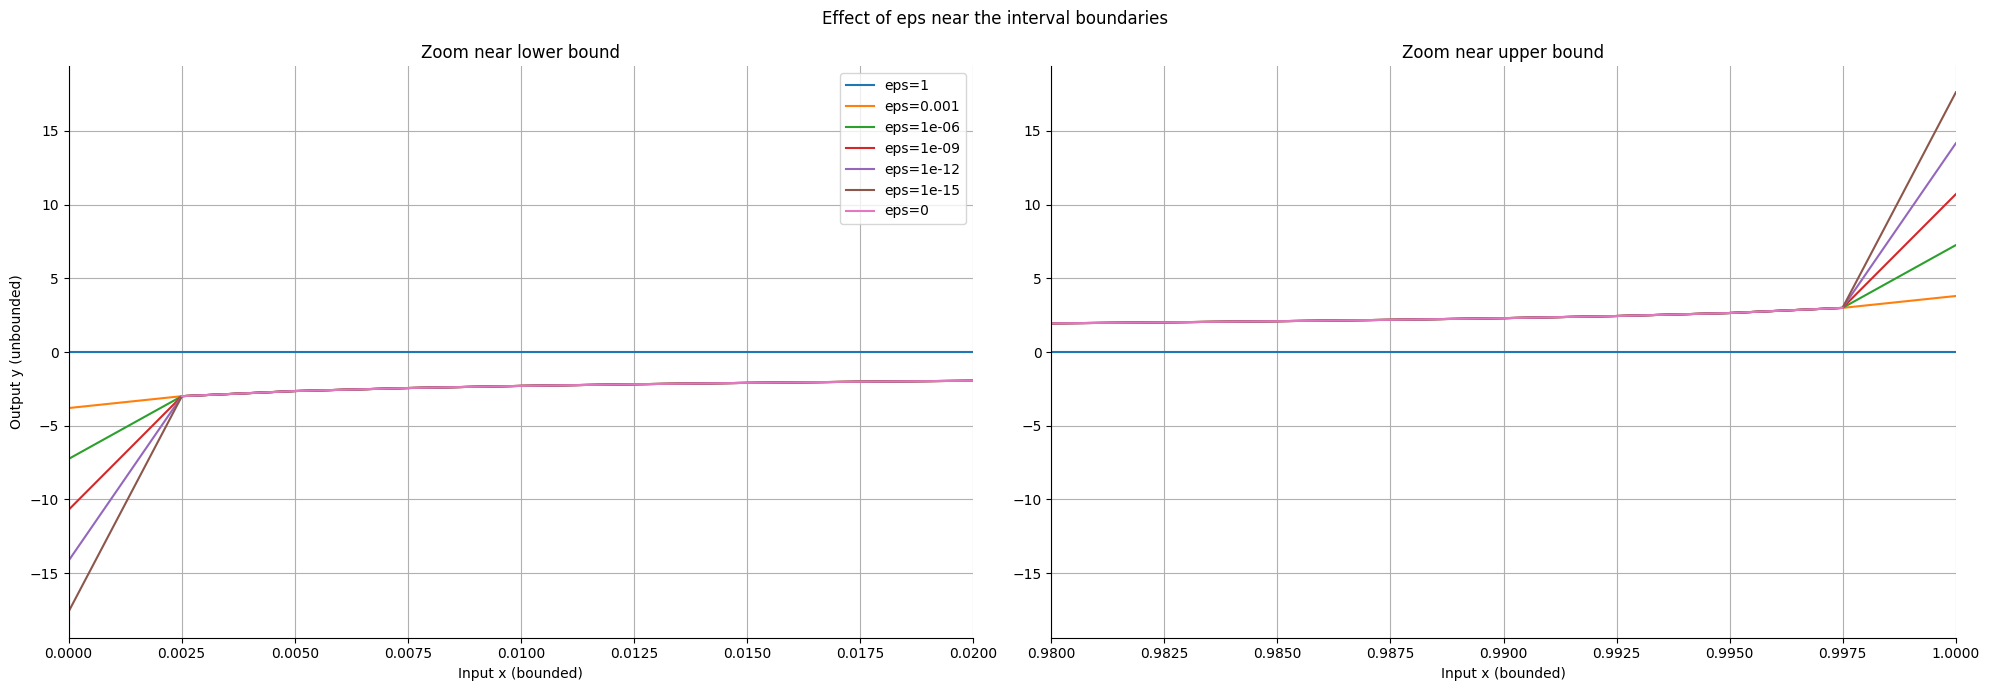

In [8]:
def visualize_eps_effect(
    min_x: float = 0.0,
    max_x: float = 1.0,
    eps_values: tuple[float] = (1.0, 1e-3, 1e-6, 1e-9, 1e-12, 1e-15, 0.0),
    n_points: int = 400,
    zoom_ratio: float = 0.02,
):
    """
    Compare the Receiver mapping for different epsilon values, focusing separately
    on the lower and upper edges of the bounded interval.

    - The first subplot zooms near the lower bound (min_x).
    - The second subplot zooms near the upper bound (max_x).

    This helps visualize how the mapping diverges as x approaches the limits.
    """
    x = np.linspace(min_x, max_x, n_points)

    fig, axes = plt.subplots(1, 2, squeeze=False)

    for eps in eps_values:
        r = Receiver(size=1, min_x=min_x, max_x=max_x, eps=eps)
        y = np.array([r.process_forward(np.array([xi]))[0] for xi in x])

        axes[0, 0].plot(x, y, label=f"eps={eps:g}")
        axes[0, 1].plot(x, y, label=f"eps={eps:g}")

    # Focus on lower and upper boundaries
    range_span = max_x - min_x
    lower_window = (min_x, min_x + zoom_ratio * range_span)
    upper_window = (max_x - zoom_ratio * range_span, max_x)

    axes[0, 0].set_xlim(*lower_window)
    axes[0, 0].set_title("Zoom near lower bound")
    axes[0, 0].set_xlabel("Input x (bounded)")
    axes[0, 0].set_ylabel("Output y (unbounded)")
    axes[0, 0].legend()

    axes[0, 1].set_xlim(*upper_window)
    axes[0, 1].set_title("Zoom near upper bound")
    axes[0, 1].set_xlabel("Input x (bounded)")

    fig.suptitle("Effect of eps near the interval boundaries")
    fig.tight_layout()
    plt.show()


visualize_eps_effect()

### Observations

- The outputs remain finite even for inputs extremely close to the bounds.
- Smaller `eps` makes the mapping steeper near the edges and increases the
  maximum magnitude of the output.
- Larger `eps` slightly "softens" the extremes, trading off a tiny amount of
  bijectivity for improved numerical robustness.

This behavior is particularly relevant when the Receiver is used alongside
gradient-based methods or when the downstream components are sensitive to
very large magnitudes.

## 5. Dynamic dimensionality (`add_dimension` / `remove_dimension`)

The Receiver supports dynamic changes in its dimensionality:

- `add_dimension` appends a new dimension with optional bounds.
- `remove_dimension` deletes a dimension and its associated bounds.

This is useful when the external environment changes (e.g. new sensors are
introduced or some inputs become obsolete).

In this section we demonstrate how the internal configuration evolves as
dimensions are added and removed.

In [9]:
# Start from a simple 2D Receiver
r_dyn = Receiver(
    size=2,
    min_x=[0.0, np.nan],
    max_x=[1.0, np.nan],
)

print("=== Initial Receiver (2D) ===")
print(f"N: {r_dyn.N}")
print(f"min_x: {r_dyn.min_x}")
print(f"max_x: {r_dyn.max_x}")
print(f"has_bounds: {r_dyn.has_bounds}")

# Add a new fully bounded dimension
r_dyn.add_dimension(min_x=-5.0, max_x=5.0)

print("\n=== After add_dimension (3D) ===")
print(f"N: {r_dyn.N}")
print(f"min_x: {r_dyn.min_x}")
print(f"max_x: {r_dyn.max_x}")
print(f"has_bounds: {r_dyn.has_bounds}")

# Remove the middle dimension (index 1)
r_dyn.remove_dimension(idx=1)

print("\n=== After remove_dimension(idx=1) (back to 2D) ===")
print(f"N: {r_dyn.N}")
print(f"min_x: {r_dyn.min_x}")
print(f"max_x: {r_dyn.max_x}")
print(f"has_bounds: {r_dyn.has_bounds}")

=== Initial Receiver (2D) ===
N: 2
min_x: [ 0. nan]
max_x: [ 1. nan]
has_bounds: [ True False]

=== After add_dimension (3D) ===
N: 3
min_x: [ 0. nan -5.]
max_x: [ 1. nan  5.]
has_bounds: [ True False  True]

=== After remove_dimension(idx=1) (back to 2D) ===
N: 2
min_x: [ 0. -5.]
max_x: [1. 5.]
has_bounds: [ True  True]


Snapshot: before adding a bounded second dimension


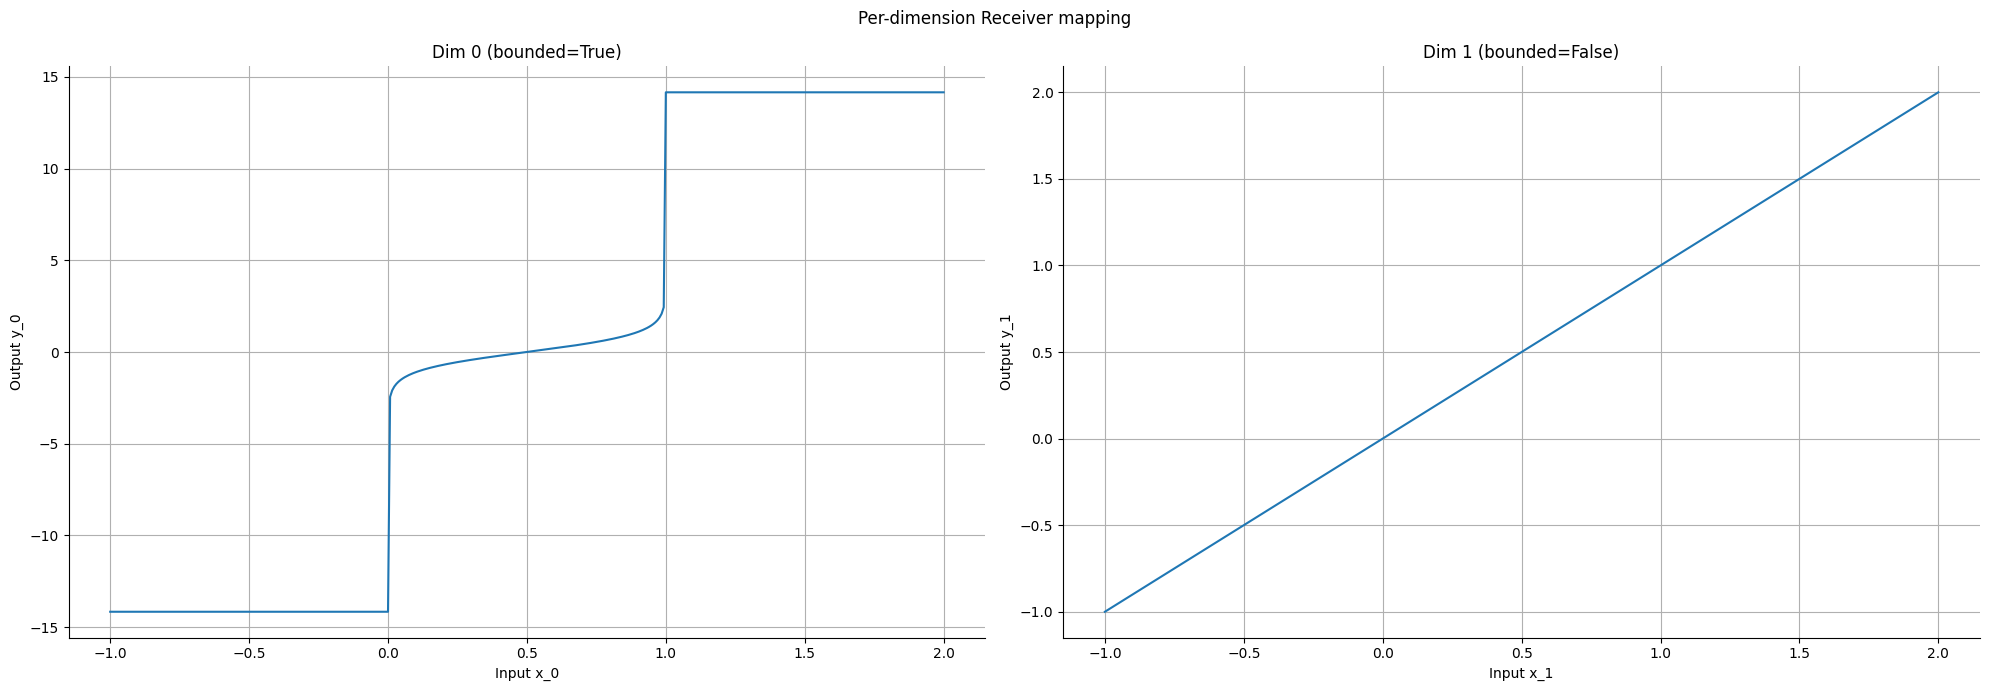

Snapshot: after adding a bounded second dimension


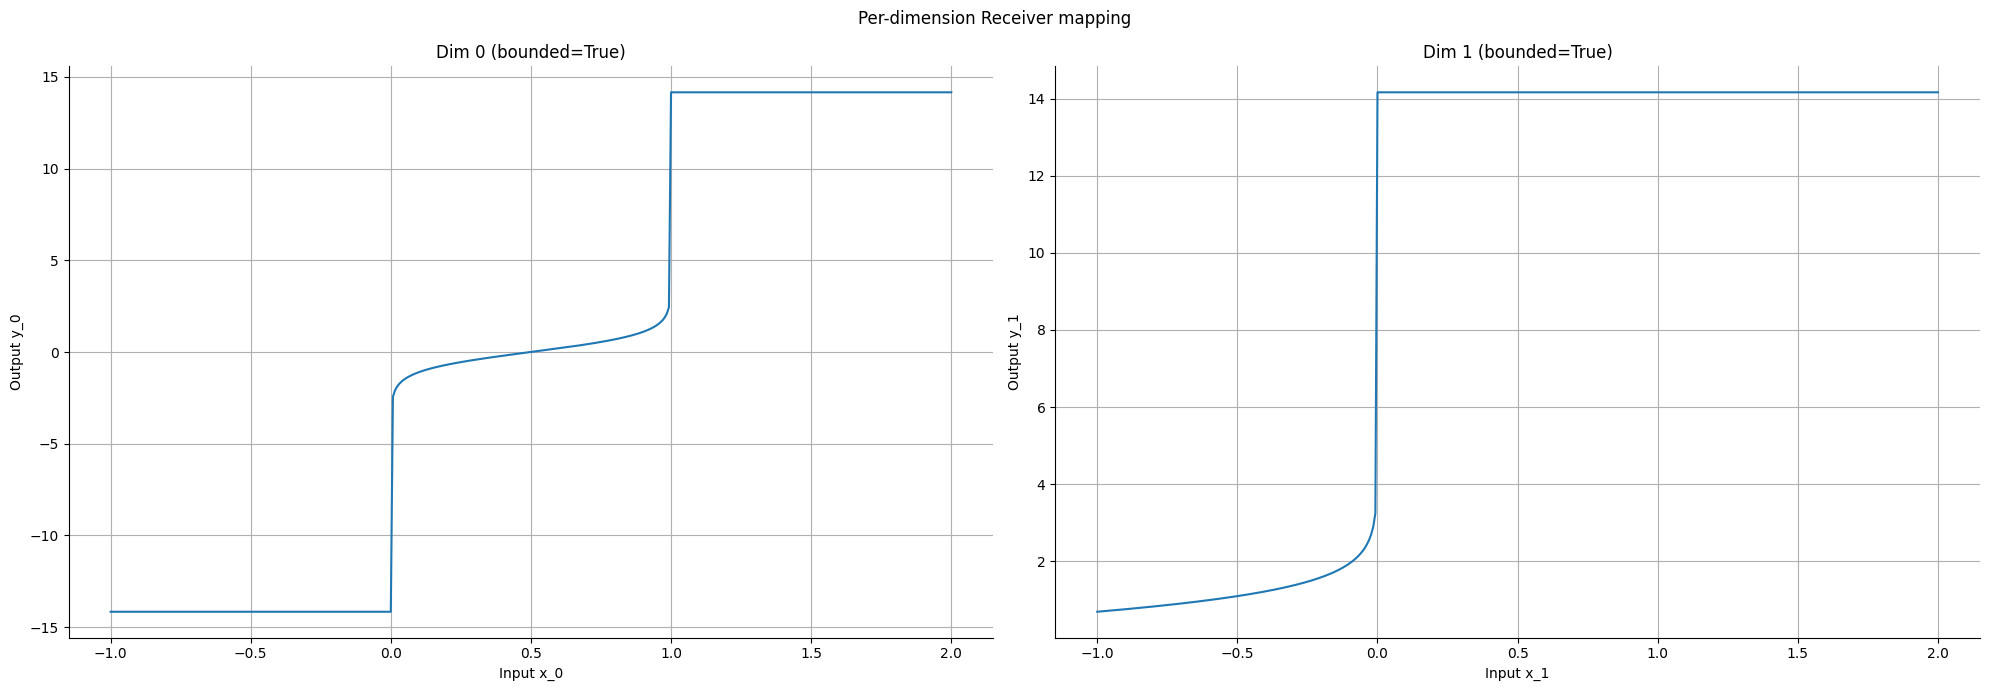

In [10]:
# Visualize the mapping for the dynamic Receiver before and after modifications

# Reconstruct two snapshots for clarity
r_before = Receiver(
    size=2,
    min_x=[0.0, np.nan],
    max_x=[1.0, np.nan],
)

r_after = Receiver(
    size=2,
    min_x=[0.0, -5.0],
    max_x=[1.0,  0.0],
)

print("Snapshot: before adding a bounded second dimension")
visualize_multidim_receiver(r_before)

print("Snapshot: after adding a bounded second dimension")
visualize_multidim_receiver(r_after)

## 6. Serialization and reconstruction

For reproducibility and experiment tracking, each Receiver can be serialized
into a pure-Python dictionary representation using `to_dict()`.

This dictionary can later be reconstructed back into a functional Receiver
instance via `from_dict()`.

Although the class also provides file-based `save()` and `load()` methods,
this section focuses on the in-memory approach to avoid creating temporary
files.

In [11]:
# Create a Receiver with mixed bounds
r_serial = Receiver(
    size=3,
    min_x=[0.0, np.nan, -1.0],
    max_x=[1.0, np.nan, 1.0],
)

# Convert to dictionary
r_dict = r_serial.to_dict()

# Reconstruct a new Receiver from that dictionary
r_clone = Receiver.from_dict(r_dict)

# Verify that both have identical configurations
print("=== Comparison check ===")
print("\nOriginal min_x:", r_serial.min_x)
print("Restored min_x:", r_clone.min_x)
print("\nOriginal max_x:", r_serial.max_x)
print("Restored max_x:", r_clone.max_x)
print("\nOriginal has_bounds:", r_serial.has_bounds)
print("Restored has_bounds:", r_clone.has_bounds)
print("\nOriginal eps:", r_serial.eps)
print("Restored eps:", r_clone.eps)


=== Comparison check ===

Original min_x: [ 0. nan -1.]
Restored min_x: [ 0. nan -1.]

Original max_x: [ 1. nan  1.]
Restored max_x: [ 1. nan  1.]

Original has_bounds: [ True False  True]
Restored has_bounds: [ True False  True]

Original eps: 1e-12
Restored eps: 1e-12


### Observations

- The `to_dict()` method produces a JSON-friendly snapshot of the Receiver’s
  configuration, suitable for saving in experiment metadata or checkpoints.
- `from_dict()` can fully reconstruct the Receiver’s state without any loss
  of information.
- The pair `save(path)` / `load(path)` are simple wrappers around these two
  methods that persist the same information to disk.

## 7. Summary and key takeaways

In this notebook we have explored the Receiver module — Jacinta’s entry
point for external inputs — and demonstrated:

- How bounded and unbounded dimensions are handled differently.
- The shape of the artanh-based mapping from `[min, max] → ℝ`.
- The role of the `eps` parameter in maintaining numerical stability.
- Mixed-dimensional behavior with selective transformation.
- Dynamic dimensionality through `add_dimension()` and `remove_dimension()`.
- In-memory serialization with `to_dict()` / `from_dict()`.

The Receiver establishes a clear, invertible boundary between external signals
and Jacinta’s internal continuous domain.  
It provides the mathematical foundation that ensures the entire system can
operate smoothly, reversibly, and consistently.